In [ ]:
from google.colab import drive
drive.mount("/content/drive/")


Mounted at /content/drive/


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys


In [ ]:
train_path = "/content/drive/MyDrive/train.csv"
test_path = "/content/drive/MyDrive/test.csv"

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
#train_df.head()
train_df=train_df.head(200)

In [ ]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
x=train_df.iloc[:,3:].sum()
rowsums=train_df.iloc[:,2:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of articles = ",len(train_df))
print("Total number of articles without label = ",no_label_count)
print("Total labels = ",x.sum())

Total number of articles =  200
Total number of articles without label =  0
Total labels =  245


<ipython-input-8-2fbd587708b6>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsums=train_df.iloc[:,2:].sum(axis=1)


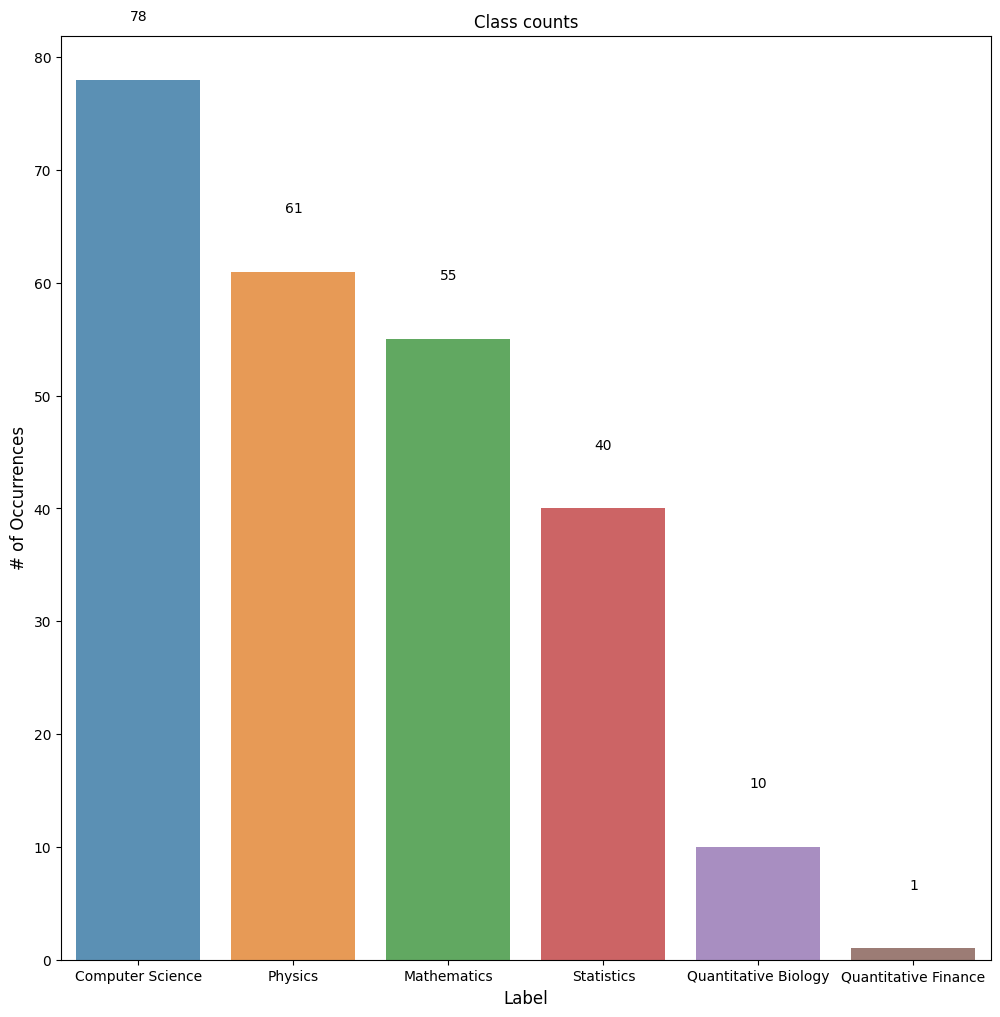

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

x = train_df.iloc[:, 3:].sum()
plt.figure(figsize=(12, 12))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Class counts")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()


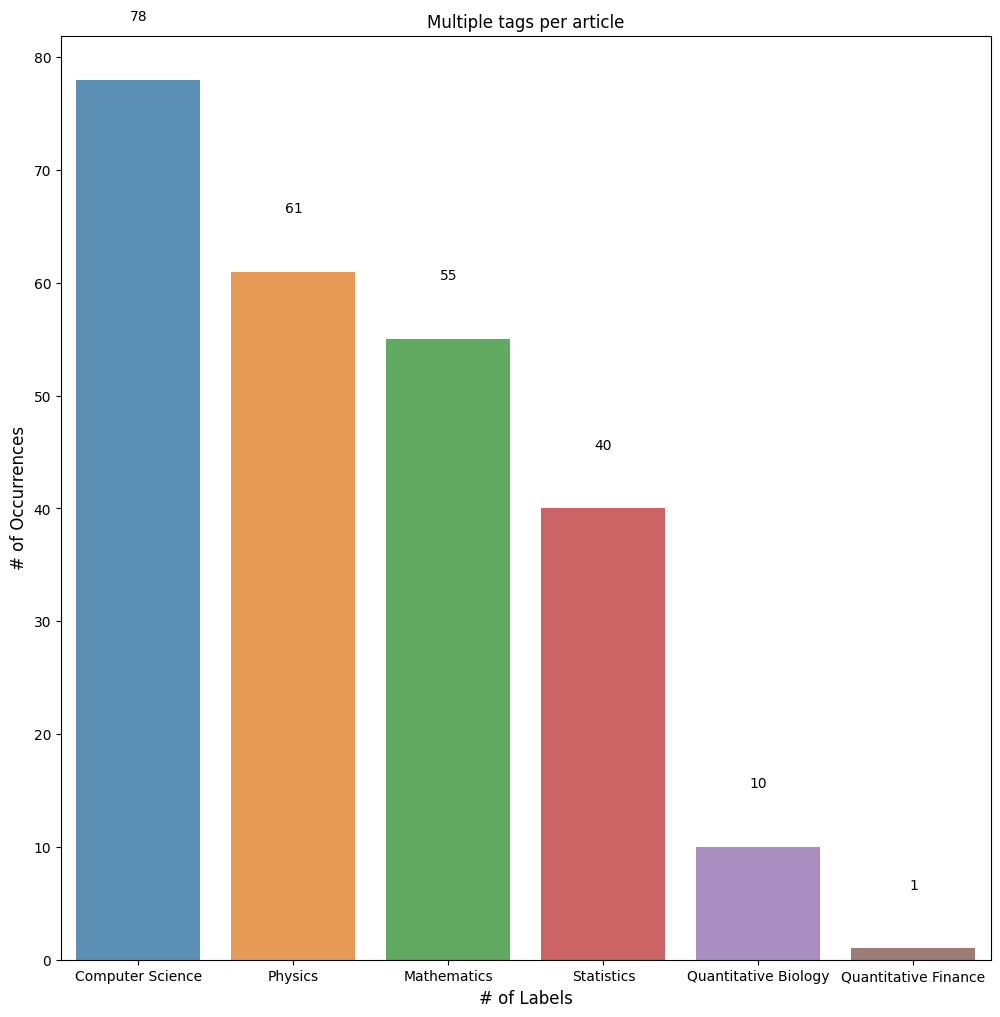

In [ ]:
plt.figure(figsize=(12, 12))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Multiple tags per article")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Labels', fontsize=12)

# Adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
train_df['Text']=train_df['TITLE']+' '+train_df['ABSTRACT']
train_df.drop(columns=['TITLE','ABSTRACT'], inplace=True)
train_df.head(10)

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...
5,6,0,0,1,0,0,0,On maximizing the fundamental frequency of the...
6,7,0,1,0,0,0,0,On the rotation period and shape of the hyperb...
7,8,0,1,0,0,0,0,Adverse effects of polymer coating on heat tra...
8,9,0,1,0,0,0,0,SPH calculations of Mars-scale collisions: the...
9,10,0,0,0,0,1,0,$\mathcal{R}_{0}$ fails to predict the outbrea...


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


In [ ]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Remove Stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = ' '.join(text.split())
    return text

# Stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_df['Text'] = train_df['Text'].apply(lambda x: remove_stopwords(x))
train_df['Text'] = train_df['Text'].apply(lambda x: clean_text(x))
train_df['Text'] = train_df['Text'].apply(stemming)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df.columns

Index(['ID', 'Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance', 'Text'],
      dtype='object')

In [ ]:
train_df = train_df[['Text', 'Computer Science', 'Physics', 'Mathematics', 'Statistics',
                     'Quantitative Biology', 'Quantitative Finance',]]

train_df.head()

,Text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,reconstruct subject specif effect map predict ...,1,0,0,0,0,0
1,rotat invari neural network rotat invari trans...,1,0,0,0,0,0
2,spheric polyharmon poisson kernel polyharmon f...,0,0,1,0,0,0
3,a finit element approxim stochast maxwel landa...,0,0,1,0,0,0
4,compar studi discret wavelet transform wavelet...,1,0,0,1,0,0


In [ ]:
target_list = ['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']

In [ ]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['Text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [ ]:
train_size = 0.8
train_df = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = train_df.drop(train_df.index).reset_index(drop=True)

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
       # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
val_targets=[]
val_outputs=[]

In [ ]:
import os

def train_model(n_epochs, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model_path):
    # Ensure parent directories exist for checkpoint and best model paths
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        train_loss = 0
        valid_loss = 0

        model.train()
        print('############# Epoch {}: Training Start   #############'.format(epoch))
        for batch_idx, data in enumerate(training_loader):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        print('############# Epoch {}: Training End     #############'.format(epoch))

        print('############# Epoch {}: Validation Start #############'.format(epoch))
        model.eval()
        val_targets = []
        val_outputs = []
        with torch.no_grad():
            if len(validation_loader) > 0:
                for batch_idx, data in enumerate(validation_loader, 0):
                    ids = data['input_ids'].to(device, dtype=torch.long)
                    mask = data['attention_mask'].to(device, dtype=torch.long)
                    token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                    targets = data['targets'].to(device, dtype=torch.float)
                    outputs = model(ids, mask, token_type_ids)

                    loss = loss_fn(outputs, targets)
                    valid_loss += loss.item()
                    val_targets.extend(targets.cpu().detach().numpy().tolist())
                    val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

                valid_loss = valid_loss / len(validation_loader)
            else:
                print('Validation Loader is empty. Skipping validation step.')
                valid_loss = 0.0

        print('############# Epoch {}: Validation End     #############'.format(epoch))

        # Calculate average losses
        train_loss = train_loss / len(training_loader)

        # Print training/validation statistics
        print('Epoch: {} \tAverage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
        ))

        # Create checkpoint variable and add important data
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        # Save checkpoint
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)

        print('############# Epoch {} Done #############\n'.format(epoch))

    return model


In [ ]:
ckpt_path = "/content/drive/MyDrive/datasets/multi-label/curr_ckpt"
best_model_path = "/content/drive/MyDrive/datasets/multi-label/best_model.pt"

In [ ]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start #############
Validation Loader is empty. Skipping validation step.
############# Epoch 1: Validation End     #############
Epoch: 1 	Average Training Loss: 0.129378 	Average Validation Loss: 0.000000
Validation loss decreased (inf --> 0.000000). Saving model ...
############# Epoch 1 Done #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start #############
Validation Loader is empty. Skipping validation step.
############# Epoch 2: Validation End     #############
Epoch: 2 	Average Training Loss: 0.115808 	Average Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000). Saving model ...
############# Epoch 2 Done #############



In [ ]:
# testing
example = test_df['ABSTRACT'][0]
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])

Computer Science
